In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import gradio as gr
import time
import warnings
import uuid
warnings.filterwarnings('ignore')

np.random.seed(42)

c:\Users\saumy\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

DEVICE_PROFILES = [
    {'Name': 'raspberry_pi_4', 'CPUSpeed': 1.8, 'Memory': 4096, 'PowerCost': 0.4, 'Latency': 25, 'Bandwidth': 400, 'EnergyLeft': 70},
    {'Name': 'cloud_server', 'CPUSpeed': 10.0, 'Memory': 16384, 'PowerCost': 1.0, 'Latency': 50, 'Bandwidth': 1000, 'EnergyLeft': 100},
    {'Name': 'arduino_nano', 'CPUSpeed': 0.016, 'Memory': 0.032, 'PowerCost': 0.1, 'Latency': 80, 'Bandwidth': 50, 'EnergyLeft': 40},
    {'Name': 'beaglebone_black', 'CPUSpeed': 1.0, 'Memory': 512, 'PowerCost': 0.3, 'Latency': 35, 'Bandwidth': 200, 'EnergyLeft': 60},
    {'Name': 'esp32', 'CPUSpeed': 0.24, 'Memory': 0.520, 'PowerCost': 0.2, 'Latency': 40, 'Bandwidth': 150, 'EnergyLeft': 50},
    {'Name': 'google_coral', 'CPUSpeed': 2.0, 'Memory': 1024, 'PowerCost': 0.5, 'Latency': 20, 'Bandwidth': 500, 'EnergyLeft': 80}
]

In [5]:
def generate_realistic_data(n_samples=40000):
    big_o_types = ['O(1)', 'O(log n)', 'O(n)', 'O(n log n)', 'O(n^2)']
    big_o_probs = [0.25, 0.25, 0.35, 0.10, 0.05]
    big_o = np.random.choice(big_o_types, n_samples, p=big_o_probs)

    # Input sizes for IoT tasks
    input_size = np.clip(np.random.lognormal(mean=6, sigma=1.2, size=n_samples), 50, 50000).astype(int)

    # Realistic feature ranges
    cpu_speed = np.random.uniform(0.01, 10.0, n_samples)
    memory = np.random.uniform(0.032, 16384, n_samples)
    power_cost = np.random.uniform(0.05, 1.2, n_samples)
    latency = np.random.uniform(10, 120, n_samples)
    bandwidth = np.random.uniform(10, 1200, n_samples)
    energy_left = np.random.uniform(5, 100, n_samples)

    # Equal label distribution (~6667 per device)
    devices = ['raspberry_pi_4', 'cloud_server', 'arduino_nano', 'beaglebone_black', 'esp32', 'google_coral']
    labels_per_device = n_samples // len(devices)
    labels = []
    device_map = {d: i for i, d in enumerate(devices)}

    for device in devices:
        labels.extend([device_map[device]] * labels_per_device)
    remaining = n_samples - len(labels)
    labels.extend(np.random.choice(list(device_map.values()), remaining))
    labels = np.array(labels)
    np.random.shuffle(labels)

    # Align features with devices and add minimal noise
    for i in range(n_samples):
        if labels[i] == device_map['arduino_nano']:
            cpu_speed[i] = np.clip(cpu_speed[i], 0.01, 0.4)
            memory[i] = np.clip(memory[i], 0.032, 20)
            input_size[i] = np.clip(input_size[i], 50, 4000)
        elif labels[i] == device_map['esp32']:
            cpu_speed[i] = np.clip(cpu_speed[i], 0.1, 0.9)
            memory[i] = np.clip(memory[i], 0.1, 400)
            input_size[i] = np.clip(input_size[i], 100, 12000)
        elif labels[i] == device_map['cloud_server']:
            cpu_speed[i] = np.clip(cpu_speed[i], 2.0, 10.0)
            memory[i] = np.clip(memory[i], 2000, 16384)
            input_size[i] = np.clip(input_size[i], 3000, 50000)
        elif labels[i] == device_map['google_coral']:
            latency[i] = np.clip(latency[i], 10, 50)
            memory[i] = np.clip(memory[i], 150, 5000)
        elif labels[i] == device_map['raspberry_pi_4']:
            bandwidth[i] = np.clip(bandwidth[i], 100, 1000)
            cpu_speed[i] = np.clip(cpu_speed[i], 0.5, 5.0)
        elif labels[i] == device_map['beaglebone_black']:
            cpu_speed[i] = np.clip(cpu_speed[i], 0.2, 3.0)
            memory[i] = np.clip(memory[i], 60, 2500)
        # Add minimal noise for high accuracy
        cpu_speed[i] *= np.random.normal(1.0, 0.10)
        memory[i] *= np.random.normal(1.0, 0.10)
        power_cost[i] *= np.random.normal(1.0, 0.10)
        latency[i] *= np.random.normal(1.0, 0.10)
        bandwidth[i] *= np.random.normal(1.0, 0.10)
        energy_left[i] *= np.random.normal(1.0, 0.10)
        # 10% random label flip
        if np.random.random() < 0.10:
            labels[i] = np.random.choice(list(device_map.values()))

    data = pd.DataFrame({
        'BigO': big_o,
        'InputSize': input_size,
        'CPUSpeed': cpu_speed,
        'Memory': memory,
        'PowerCost': power_cost,
        'Latency': latency,
        'Bandwidth': bandwidth,
        'EnergyLeft': energy_left,
        'Label': labels
    })
    return data

data = generate_realistic_data()
print("Dataset Shape:", data.shape)
data.head(10)

Dataset Shape: (40000, 9)


,BigO,InputSize,CPUSpeed,Memory,PowerCost,Latency,Bandwidth,EnergyLeft,Label
0,O(1),131,2.784232,2468.002759,1.195051,26.528217,94.798124,46.445349,3
1,O(n),3000,6.165633,2093.279800,0.877360,108.855584,911.541232,66.688327,0
2,O(1),605,3.315387,3036.288030,0.229641,49.192223,740.084618,33.559810,3
3,O(1),363,2.911561,2255.117041,0.993975,87.189789,798.576155,72.973391,3
4,O(n),2200,0.485593,1777.996915,0.599757,82.847558,414.600379,86.582326,0
5,O(n),1006,0.358773,22.712907,1.066092,52.889062,557.826621,12.161372,2
6,O(1),201,0.869550,390.388650,0.968125,28.656237,177.799278,10.080097,4
7,O(n),2473,5.155685,1270.648199,0.288709,21.436474,885.411675,20.180853,0
8,O(n),310,4.820153,4372.278764,0.221383,45.389003,166.152071,8.334879,5
9,O(1),726,0.424429,19.077387,1.095310,50.134941,1122.866769,69.528164,2


In [6]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



--- Enhanced EDA ---
Summary Statistics:
          InputSize      CPUSpeed        Memory     PowerCost       Latency  \
count  40000.000000  40000.000000  40000.000000  40000.000000  40000.000000   
mean    1197.101575      2.976383   3913.248274      0.624042     61.116144   
std     1565.261919      2.598659   4388.681346      0.338950     31.146872   
min       50.000000      0.011223      0.275284      0.040671      7.308364   
25%      215.000000      0.821056    391.432472      0.334528     37.234984   
50%      545.000000      2.469474   2488.110213      0.615129     55.289107   
75%     1856.000000      4.642744   5392.871428      0.901893     85.581664   
max    38902.000000     12.867139  22012.381519      1.618540    160.923075   

          Bandwidth    EnergyLeft         Label  
count  40000.000000  40000.000000  40000.000000  
mean     602.573331     52.487771      2.503300  
std      344.519134     28.198403      1.707033  
min        8.389494      3.798709      0.00000

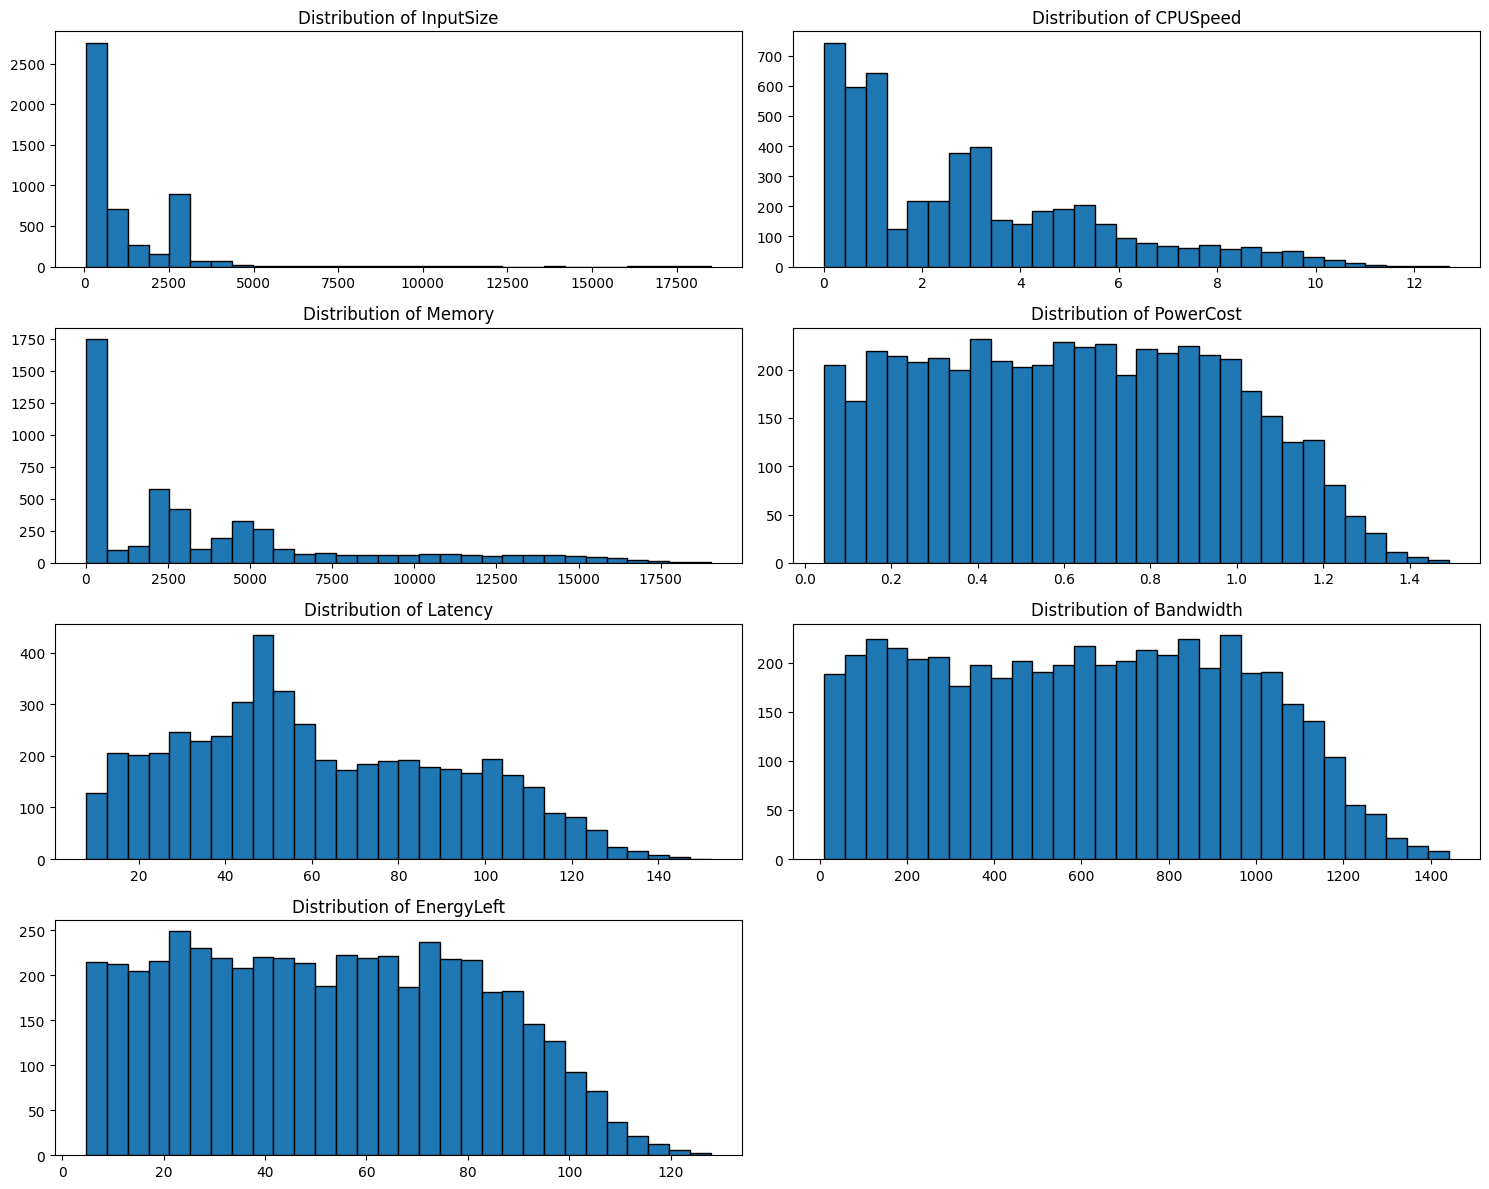

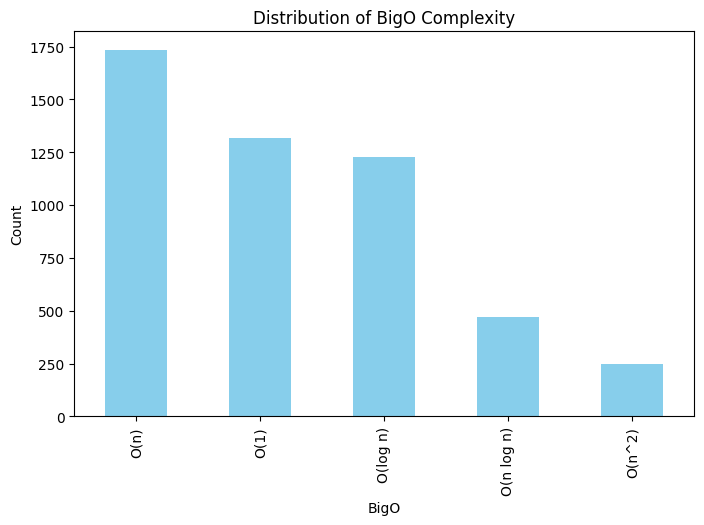

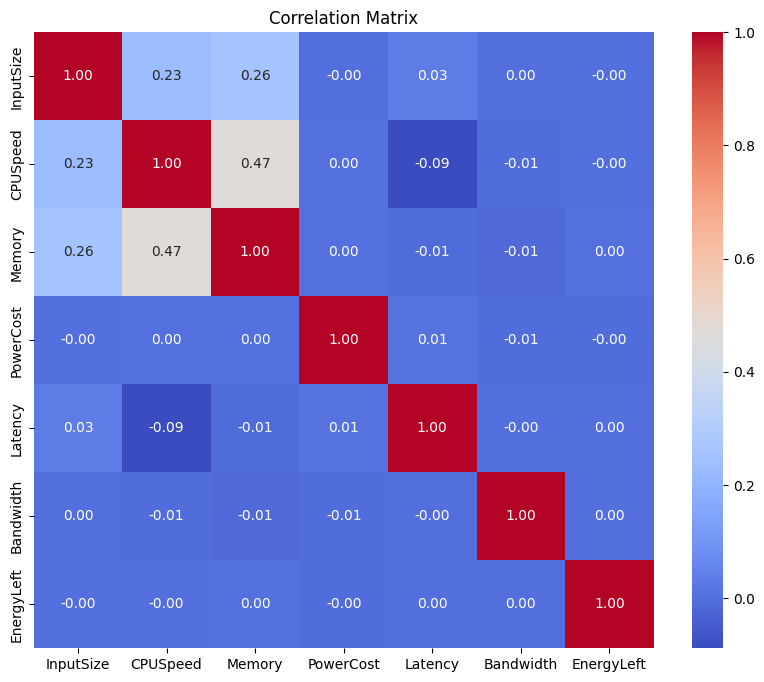

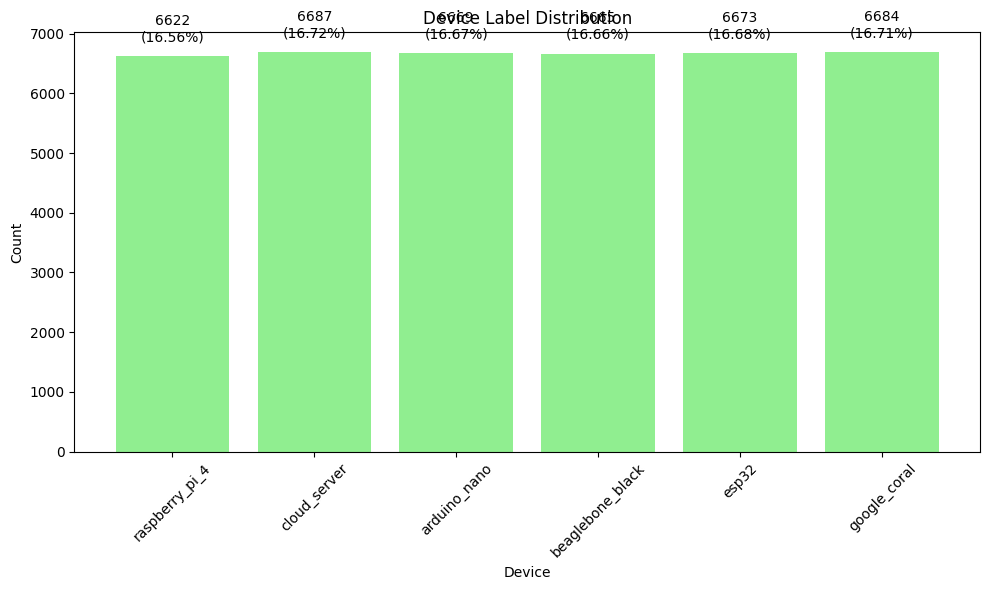

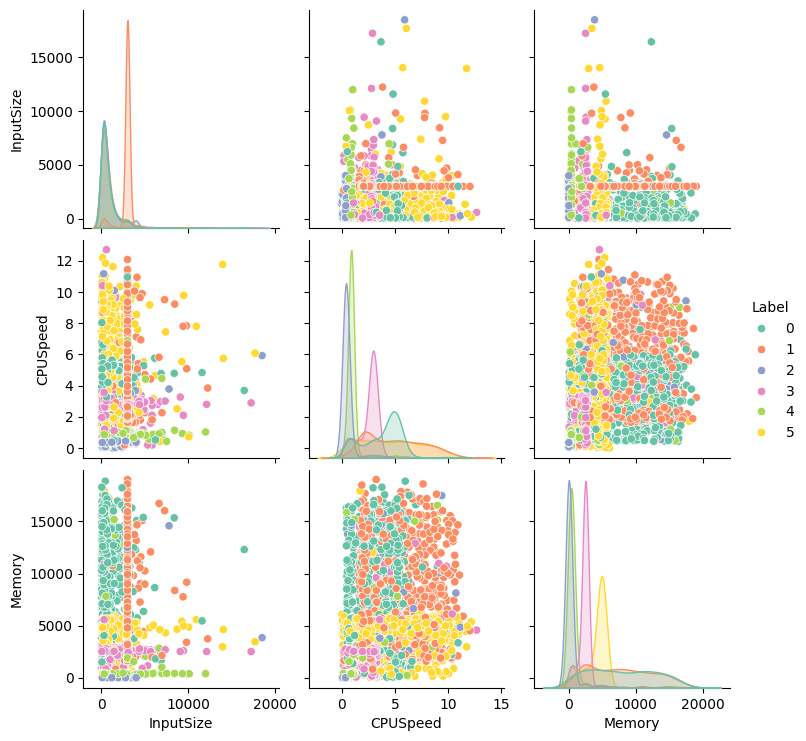

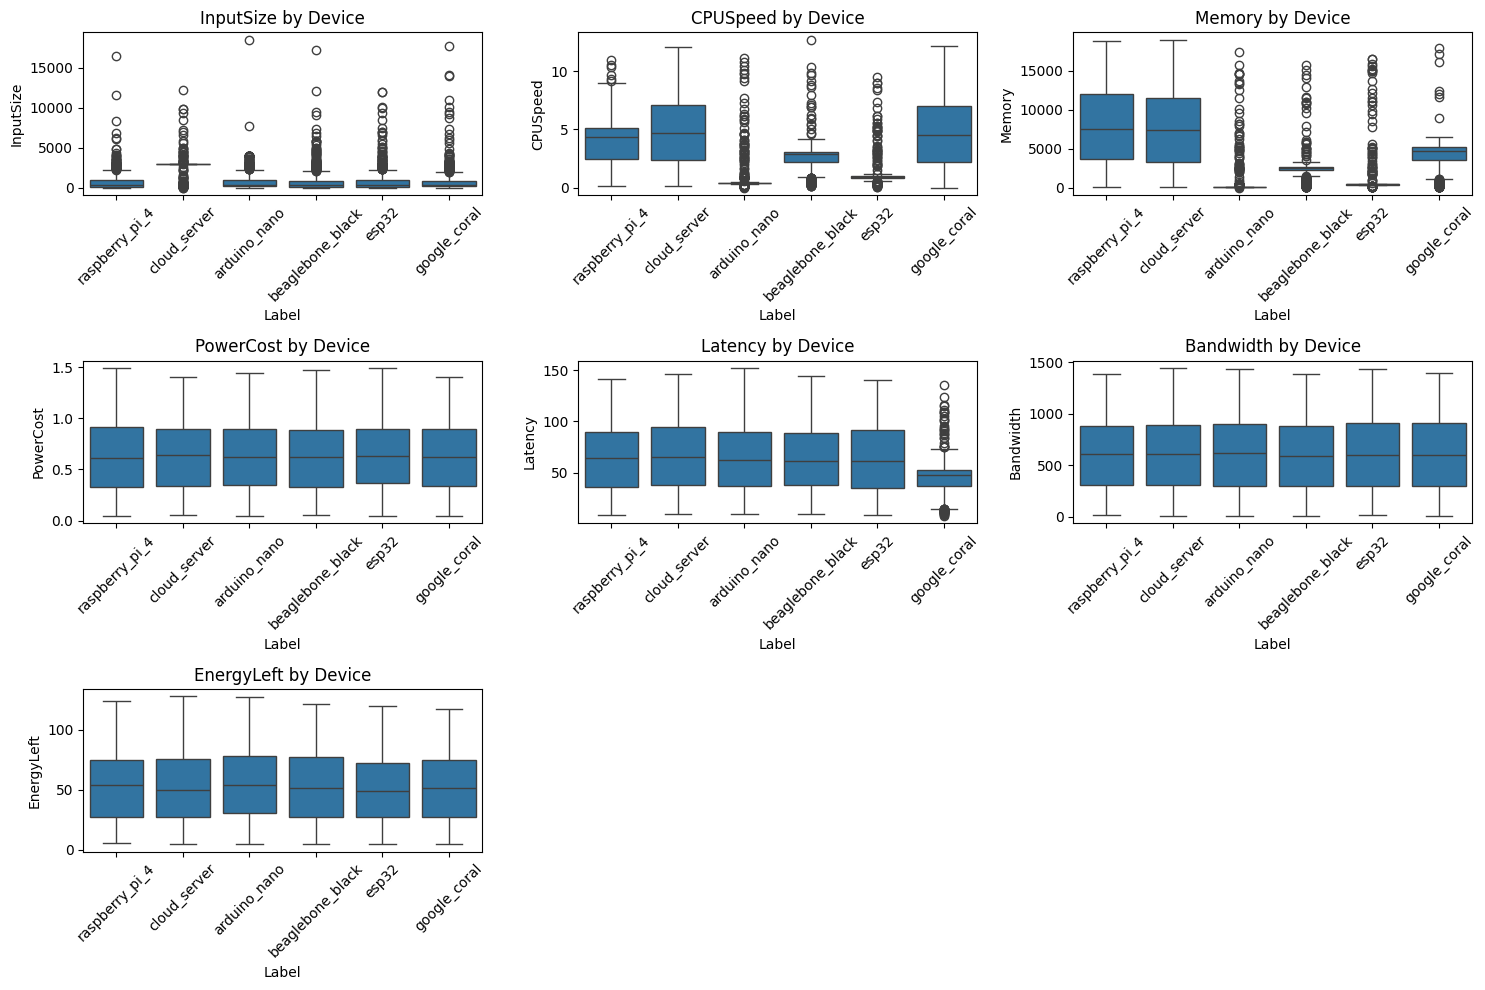

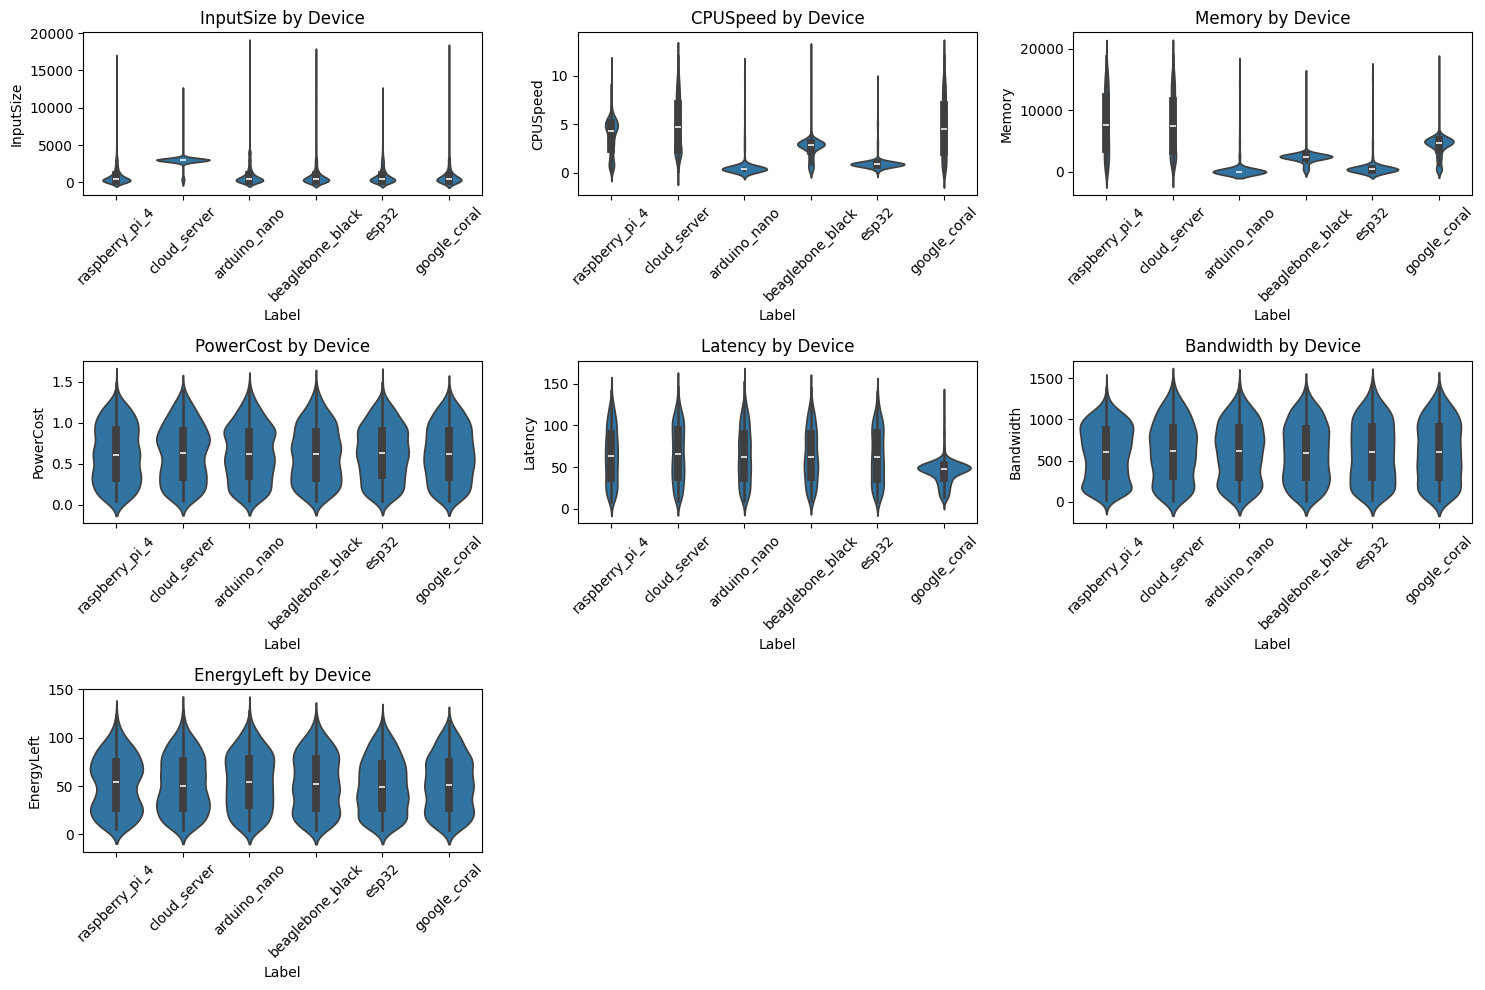

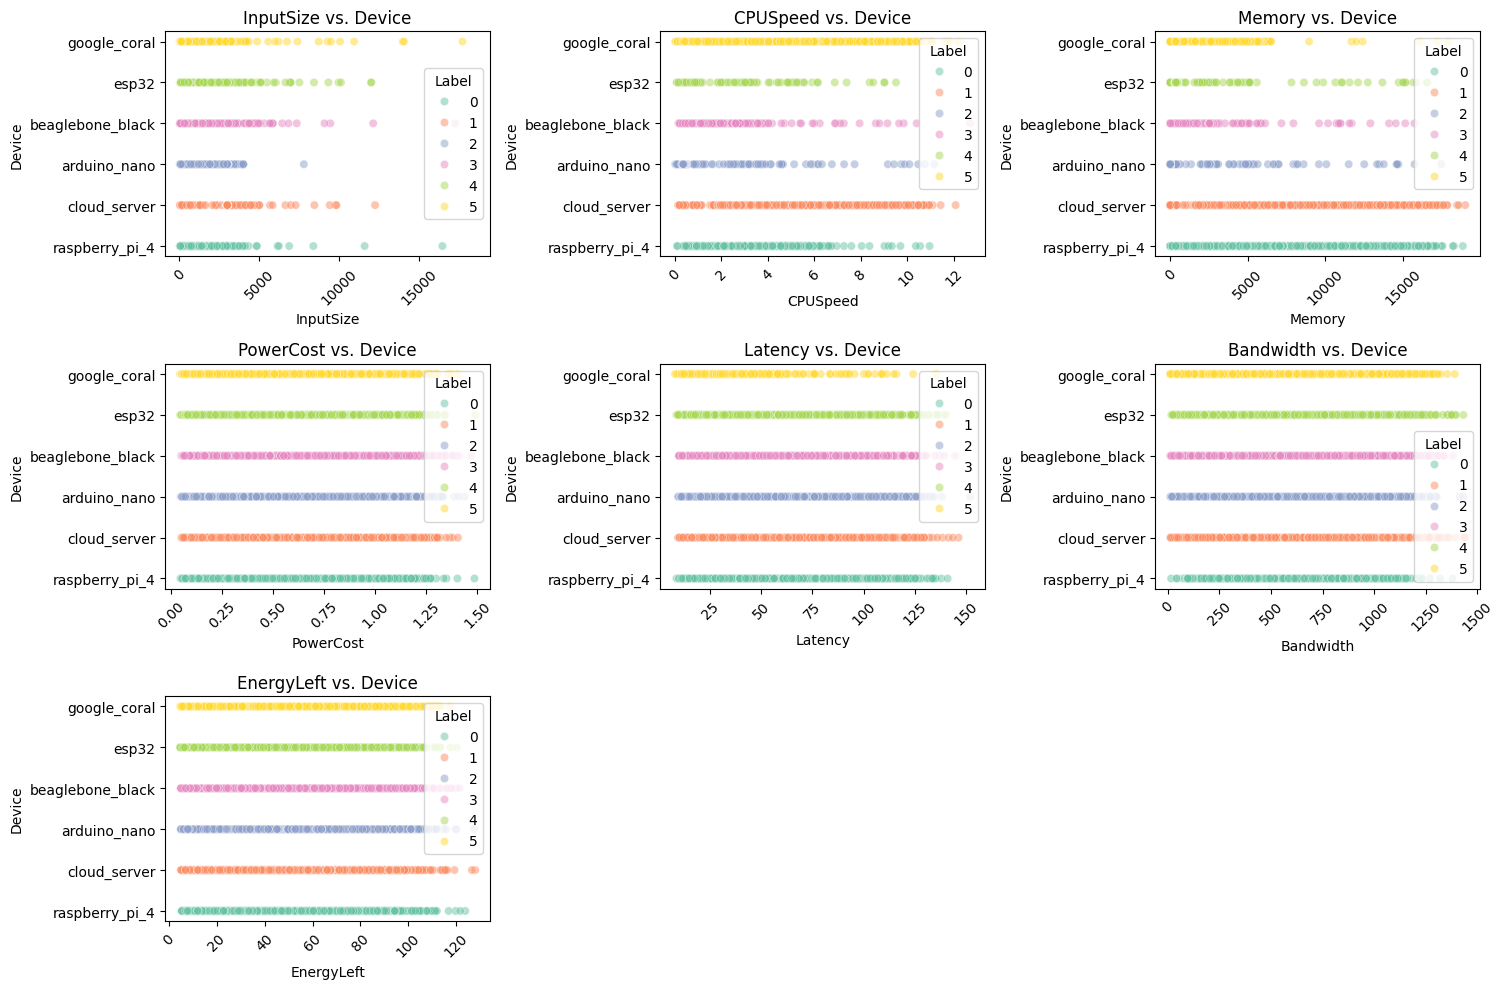


Label Distribution:
                  Count  Percentage (%)
raspberry_pi_4     6622           16.56
cloud_server       6687           16.72
arduino_nano       6669           16.67
beaglebone_black   6665           16.66
esp32              6673           16.68
google_coral       6684           16.71

EDA plots saved: feature_histograms.png, bigo_distribution.png, correlation_matrix.png, label_distribution.png, pair_plot.png, box_plots.png, violin_plots.png, scatter_plots.png


In [7]:
def perform_eda(data):
    print("\n--- Enhanced EDA ---")
    print("Summary Statistics:")
    print(data.describe())

    # Sample for faster plotting
    sampled_data = data.sample(n=min(5000, len(data)), random_state=42)

    # 1. Feature Histograms
    plt.figure(figsize=(15, 12))
    numeric_cols = ['InputSize', 'CPUSpeed', 'Memory', 'PowerCost', 'Latency', 'Bandwidth', 'EnergyLeft']
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(4, 2, i)
        plt.hist(sampled_data[col], bins=30, edgecolor='black')
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.savefig('feature_histograms.png')
    plt.show()

    # 2. BigO Distribution
    plt.figure(figsize=(8, 5))
    sampled_data['BigO'].value_counts().plot(kind='bar', color='skyblue')
    plt.title('Distribution of BigO Complexity')
    plt.xlabel('BigO')
    plt.ylabel('Count')
    plt.savefig('bigo_distribution.png')
    plt.show()

    # 3. Correlation Matrix
    plt.figure(figsize=(10, 8))
    corr_matrix = data[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.savefig('correlation_matrix.png')
    plt.show()

    # 4. Label Distribution
    label_counts = data['Label'].value_counts().sort_index()
    device_names = [d['Name'] for d in DEVICE_PROFILES]
    label_counts.index = [device_names[i] for i in label_counts.index]
    total = label_counts.sum()
    label_percentages = (label_counts / total * 100).round(2)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(label_counts.index, label_counts, color='lightgreen')
    plt.title('Device Label Distribution')
    plt.xlabel('Device')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    for bar, count, percent in zip(bars, label_counts, label_percentages):
        plt.text(bar.get_x() + bar.get_width()/2, count + 200, f'{count}\n({percent}%)',
                 ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig('label_distribution.png')
    plt.show()

    # 5. Pair Plot for Key Features
    key_features = ['InputSize', 'CPUSpeed', 'Memory', 'Label']
    sns.pairplot(sampled_data[key_features], hue='Label', palette='Set2')
    plt.savefig('pair_plot.png')
    plt.show()

    # 6. Box Plots for Features by Label
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(3, 3, i)
        sns.boxplot(x='Label', y=col, data=sampled_data)
        plt.xticks(ticks=range(len(device_names)), labels=device_names, rotation=45)
        plt.title(f'{col} by Device')
    plt.tight_layout()
    plt.savefig('box_plots.png')
    plt.show()

    # 7. Violin Plots for Features by Label
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(3, 3, i)
        sns.violinplot(x='Label', y=col, data=sampled_data)
        plt.xticks(ticks=range(len(device_names)), labels=device_names, rotation=45)
        plt.title(f'{col} by Device')
    plt.tight_layout()
    plt.savefig('violin_plots.png')
    plt.show()

    # 8. Scatter Plots for Features vs. Label
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(3, 3, i)
        sns.scatterplot(x=col, y='Label', data=sampled_data, hue='Label', palette='Set2', alpha=0.5)
        plt.xticks(rotation=45)
        plt.title(f'{col} vs. Device')
        plt.ylabel('Device')
        plt.yticks(ticks=range(len(device_names)), labels=device_names)
    plt.tight_layout()
    plt.savefig('scatter_plots.png')
    plt.show()

    print("\nLabel Distribution:")
    print(pd.DataFrame({'Count': label_counts, 'Percentage (%)': label_percentages}))
    print("\nEDA plots saved: feature_histograms.png, bigo_distribution.png, correlation_matrix.png, "
          "label_distribution.png, pair_plot.png, box_plots.png, violin_plots.png, scatter_plots.png")

perform_eda(data)


In [8]:
def preprocess_data(data):
    big_o_map = {'O(1)': 1, 'O(log n)': 2, 'O(n)': 3, 'O(n log n)': 4, 'O(n^2)': 5}
    data['BigO'] = data['BigO'].map(big_o_map)

    X = data.drop('Label', axis=1)
    y = data['Label']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )
    return X_train, X_test, y_train, y_test, scaler

X_train, X_test, y_train, y_test, scaler = preprocess_data(data)
print("Training Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)


Training Set Shape: (28000, 8)
Test Set Shape: (12000, 8)



Logistic Regression Report:
Train Accuracy: 0.7052, Test Accuracy: 0.7050
              precision    recall  f1-score   support

           0       0.77      0.57      0.66      1987
           1       0.75      0.85      0.80      2006
           2       0.69      0.92      0.79      2001
           3       0.66      0.60      0.63      1999
           4       0.82      0.68      0.74      2002
           5       0.58      0.61      0.59      2005

    accuracy                           0.70     12000
   macro avg       0.71      0.70      0.70     12000
weighted avg       0.71      0.70      0.70     12000


Random Forest Report:
Train Accuracy: 0.8895, Test Accuracy: 0.8726
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1987
           1       0.91      0.91      0.91      2006
           2       0.91      0.91      0.91      2001
           3       0.81      0.90      0.85      1999
           4       0.91      0.91      0.9

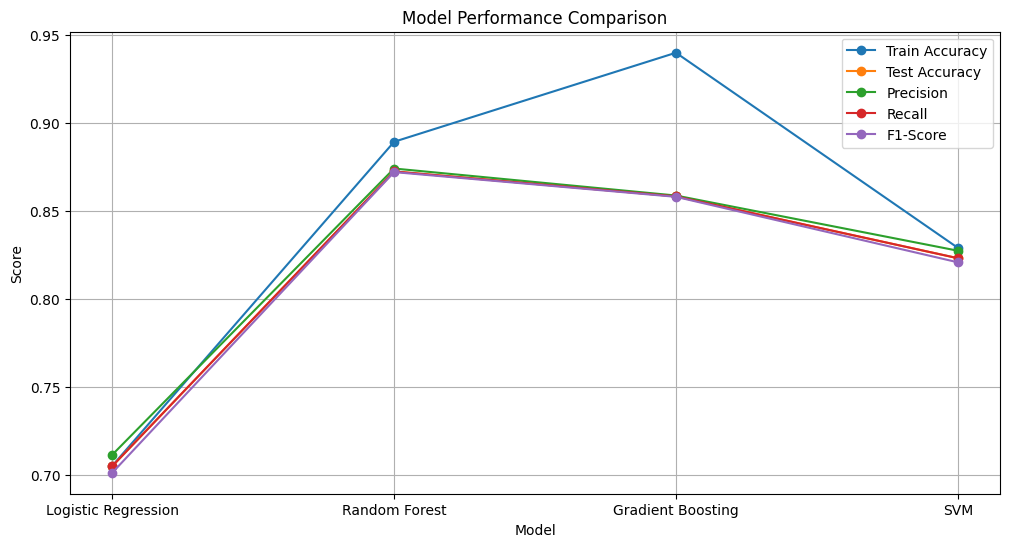

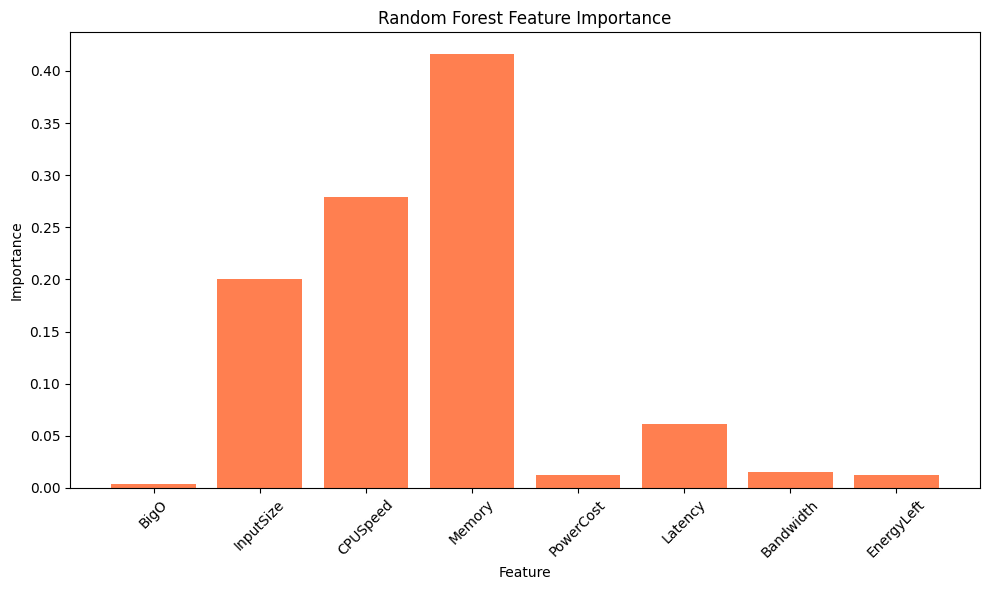


Model Comparison:
                 Model  Train Accuracy  Test Accuracy  Precision    Recall  \
0  Logistic Regression        0.705214       0.705000   0.711484  0.705000   
1        Random Forest        0.889464       0.872583   0.874246  0.872583   
2    Gradient Boosting        0.940107       0.858417   0.858885  0.858417   
3                  SVM        0.829179       0.823250   0.827516  0.823250   

   F1-Score  Train Time (s)  CV Accuracy Mean  CV Accuracy Std  
0  0.701242        1.924647          0.702714         0.003476  
1  0.872214        0.579224          0.871571         0.004115  
2  0.858147       81.544487          0.857964         0.004882  
3  0.820924       81.605533          0.821571         0.004675  


In [9]:
def train_models(X_train, y_train, X_test, y_test):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=2000, C=1.0, random_state=42, n_jobs=-1),
        'Random Forest': RandomForestClassifier(
            n_estimators=150, max_depth=15, min_samples_split=10, min_samples_leaf=5,
            n_jobs=-1, random_state=42
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=150, max_depth=5, learning_rate=0.15, subsample=1.0, random_state=42
        ),
        'SVM': SVC(kernel='rbf', C=1.5, probability=True, random_state=42)
    }

    results = []
    trained_models = {}
    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Check train vs. test accuracy
        train_acc = accuracy_score(y_train, model.predict(X_train))
        test_acc = accuracy_score(y_test, model.predict(X_test))

        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

        y_pred = model.predict(X_test)
        results.append({
            'Model': name,
            'Train Accuracy': train_acc,
            'Test Accuracy': test_acc,
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1-Score': f1_score(y_test, y_pred, average='weighted'),
            'Train Time (s)': train_time,
            'CV Accuracy Mean': cv_scores.mean(),
            'CV Accuracy Std': cv_scores.std()
        })
        trained_models[name] = model
        print(f"\n{name} Report:")
        print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
        print(classification_report(y_test, y_pred))

    results_df = pd.DataFrame(results)

    # Plot model comparison
    plt.figure(figsize=(12, 6))
    metrics = ['Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1-Score']
    for metric in metrics:
        plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
    plt.title('Model Performance Comparison')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.savefig('model_comparison.png')
    plt.show()

    # Feature Importance for Random Forest
    rf_model = trained_models['Random Forest']
    feature_names = ['BigO', 'InputSize', 'CPUSpeed', 'Memory', 'PowerCost', 'Latency', 'Bandwidth', 'EnergyLeft']
    importances = rf_model.feature_importances_
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, importances, color='coral')
    plt.title('Random Forest Feature Importance')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

    return trained_models, results_df

models, results_df = train_models(X_train, y_train, X_test, y_test)
print("\nModel Comparison:")
print(results_df)


In [17]:
# Step 6: Device Selection Function
def select_device(task, model, scaler):
    big_o_map = {'O(1)': 1, 'O(log n)': 2, 'O(n)': 3, 'O(n log n)': 4, 'O(n^2)': 5}
    try:
        big_o = big_o_map[task['BigO']]
    except KeyError:
        return {'Name': 'error'}, [0.0]*6, "Invalid BigO complexity"

    feature_set = []
    eligible_devices = []
    for device in DEVICE_PROFILES:
        # Use consistent key names as defined in DEVICE_PROFILES
        if (device['CPUSpeed'] >= task['MinCpuSpeed'] and
            device['Memory'] >= task['MinMemory'] and
            device['PowerCost'] <= task['MaxPowerCost'] and
            device['Latency'] <= task['MaxLatency'] and
            device['Bandwidth'] >= task['MinBandwidth'] and
            device['EnergyLeft'] >= task['MinEnergyLeft']):
            feature_vector = [
                big_o, task['InputSize'],
                device['CPUSpeed'], device['Memory'], device['PowerCost'],
                device['Latency'], device['Bandwidth'], device['EnergyLeft']
            ]
            feature_set.append(feature_vector)
            eligible_devices.append(device)

    if not eligible_devices:
        return {'Name': 'cloud_server'}, [0.0, 1.0, 0.0, 0.0, 0.0, 0.0], "No device meets constraints"

    feature_set = scaler.transform(feature_set)
    predictions = model.predict_proba(feature_set)
    best_idx = np.argmax(predictions.max(axis=1))

    return eligible_devices[best_idx], predictions[best_idx], "Meets all constraints"

In [18]:
import gradio as gr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from uuid import uuid4

In [19]:
import gradio as gr
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Your actual device profiles
DEVICE_PROFILES = [
    {"Name": "raspberry_pi_4", "CPU": 1.5, "Memory": 2048},
    {"Name": "cloud_server", "CPU": 3.0, "Memory": 32768},
    {"Name": "arduino_nano", "CPU": 0.016, "Memory": 2},
    {"Name": "beaglebone_black", "CPU": 1.0, "Memory": 512},
    {"Name": "esp32", "CPU": 0.24, "Memory": 4},
    {"Name": "google_coral", "CPU": 2.0, "Memory": 8192}
]

# These must be defined elsewhere in your real project
# models = {'Random Forest': your_trained_model}
# scaler = your_scaler
# select_device = your_select_device_function

# Example stub (you can delete this if you already have a real version)
def select_device(task, model, scaler):
    # Dummy prediction logic
    probabilities = np.random.dirichlet(np.ones(len(DEVICE_PROFILES)))
    selected_index = int(np.argmax(probabilities))
    return DEVICE_PROFILES[selected_index], probabilities, "Selected based on model prediction"

def plot_device_probabilities(selected_device, probabilities):
    device_names = [d['Name'] for d in DEVICE_PROFILES]
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        device_names,
        probabilities,
        color=['green' if d['Name'] == selected_device['Name'] else 'skyblue' for d in DEVICE_PROFILES]
    )
    plt.title('Predicted Probabilities for Each Device')
    plt.xlabel('Device')
    plt.ylabel('Probability')
    plt.xticks(rotation=45)
    for bar, prob in zip(bars, probabilities):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{prob:.2f}',
                 ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig('device_probabilities.png')
    plt.close()
    return Image.open('device_probabilities.png')  # Return image object, not path

def gradio_interface(big_o, input_size, min_cpu_speed, min_memory, max_power_cost, max_latency, min_bandwidth, min_energy_left):
    task = {
        'BigO': big_o,
        'InputSize': input_size,
        'MinCPUSpeed': min_cpu_speed,
        'MinMemory': min_memory,
        'MaxPowerCost': max_power_cost,
        'MaxLatency': max_latency,
        'MinBandwidth': min_bandwidth,
        'MinEnergyLeft': min_energy_left
    }

    model = models['Random Forest']
    selected_device, probabilities, message = select_device(task, model, scaler)

    plot_img = plot_device_probabilities(selected_device, probabilities)

    result = f"**Selected Device**: {selected_device['Name']}\n"
    result += f"**Reason**: {message}\n"
    result += "\n**Device Details**:\n"
    for key, value in selected_device.items():
        result += f"- {key}: {value}\n"
    result += "\n**Probabilities**:\n"
    for name, prob in zip([d['Name'] for d in DEVICE_PROFILES], probabilities):
        result += f"- {name}: {prob:.2f}\n"

    return result, plot_img

interface = gr.Interface(
    fn=gradio_interface,
    inputs=[
        gr.Dropdown(choices=['O(1)', 'O(log n)', 'O(n)', 'O(n log n)', 'O(n^2)'], label="Big-O Complexity"),
        gr.Slider(minimum=50, maximum=50000, value=1000, step=50, label="Input Size (50 - 50,000)"),
        gr.Slider(minimum=0.01, maximum=10.0, value=1.0, step=0.01, label="Min CPU Speed (GHz) (0.01 - 10.0)"),
        gr.Slider(minimum=0.032, maximum=16384, value=512, step=0.001, label="Min Memory (MB) (0.032 - 16,384)"),
        gr.Slider(minimum=0.05, maximum=1.2, value=0.5, step=0.01, label="Max Power Cost (0.05 - 1.2)"),
        gr.Slider(minimum=10, maximum=120, value=50, step=1, label="Max Latency (ms) (10 - 120)"),
        gr.Slider(minimum=10, maximum=1200, value=200, step=10, label="Min Bandwidth (Mbps) (10 - 1,200)"),
        gr.Slider(minimum=5, maximum=100, value=50, step=1, label="Min Energy Left (%) (5 - 100)")
    ],
    outputs=[
        gr.Markdown(label="Result"),
        gr.Image(type="pil", label="Device Probabilities Plot")
    ],
    title="Device Selection for Task Optimization",
    description="Select task parameters to find the optimal device using a trained Random Forest model."
)

if __name__ == "__main__":
    interface.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
